In [2]:
import numpy as np
import matplotlib.pyplot as plt
from foraging_environment import ForagingEnvironment

# Environment Test

## Initialize the environment

In [3]:
env = ForagingEnvironment()
env_info = {"time_step_duration": 0.1, "session_duration_min": 8, "seed": 42}
env.env_init(env_info)
print("--- Start Environment Testing ---")

--- Start Environment Testing ---


## Test 1: Single Trajectory "Smoke Test"


--- Running Test 1: Single Trajectory Smoke Test ---


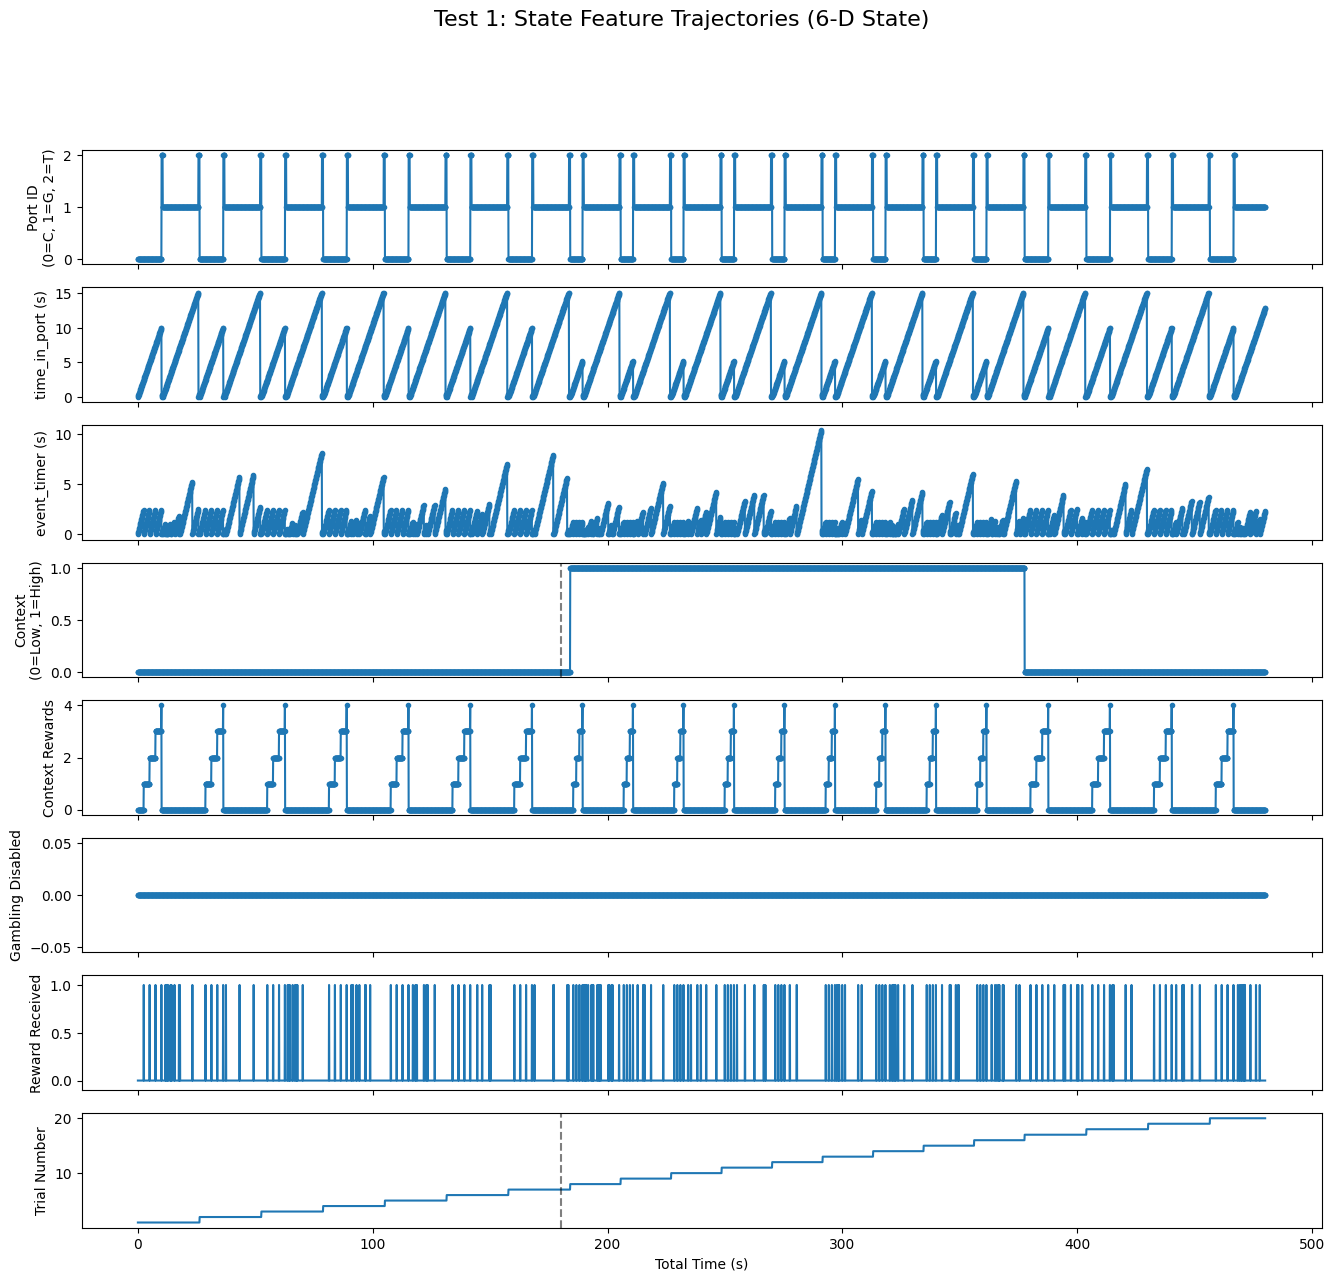

In [4]:
print("\n--- Running Test 1: Single Trajectory Smoke Test ---")
observation = env.env_start()
states = [observation]
total_reward = 0
is_terminal = False

rewards_received = [0]
trial_numbers = [1]
# simple dummy policy: stay for 15 sec in any port then leave
LEAVE_TIME = 15

while not is_terminal:
    port_id, time_in_port, event_timer, context, rewards, disabled = observation
    action = 0 # Default to stay

    if port_id == 2 and time_in_port >= env.travel_time:
        action = 1
    elif port_id == env.CONTEXT_PORT and rewards == env.context_rewards_max:
        action = 1 # Leave after finishing context
    elif port_id == env.GAMBLING_PORT and time_in_port >= LEAVE_TIME:
        action = 1 # Leave gambling after 15s

    reward, observation, is_terminal = env.env_step(action)
    states.append(observation)
    rewards_received.append(reward)
    trial_numbers.append(env.env_message("get_trial_number"))

states = np.array(states)
rewards_received = np.array(rewards_received)
trial_numbers = np.array(trial_numbers)

# Plot the state features over time
fig, axes = plt.subplots(8, 1, figsize=(16, 14), sharex=True)
time_points = np.arange(states.shape[0]) * env.dt

axes[0].plot(time_points, states[:, 0], '.-')
axes[0].set_ylabel("Port ID\n(0=C, 1=G, 2=T)")
axes[1].plot(time_points, states[:, 1], '.-')
axes[1].set_ylabel("time_in_port (s)")
axes[2].plot(time_points, states[:, 2], '.-')
axes[2].set_ylabel("event_timer (s)")
axes[3].plot(time_points, states[:, 3], '.-')
axes[3].set_ylabel("Context\n(0=Low, 1=High)")
axes[4].plot(time_points, states[:, 4], '.-')
axes[4].set_ylabel("Context Rewards")
axes[5].plot(time_points, states[:, 5], '.-')
axes[5].set_ylabel("Gambling Disabled")
axes[6].plot(time_points, rewards_received, '-')
axes[6].set_ylabel("Reward Received")
axes[6].set_ylim([-0.1, 1.1])
axes[7].plot(time_points, trial_numbers, '-')
axes[7].set_ylabel("Trial Number")
axes[7].set_xlabel("Total Time (s)")
axes[3].axvline(x=env.block_duration, color='k', linestyle='--', alpha=0.5)
axes[7].axvline(x=env.block_duration, color='k', linestyle='--', alpha=0.5)
fig.suptitle("Test 1: State Feature Trajectories (6-D State)", fontsize=16)
plt.show()

## Test 2: Context Port Validation

### 2a: Staying in the context port delivers exactly 4 rewards at the correct times and then stops

In [5]:
print("\n--- Running Test 2: Context Port Validation ---")
observation = env.env_start()
is_terminal = False
reward_times = []

while not is_terminal and observation[0] == env.CONTEXT_PORT:
    reward, observation, is_terminal = env.env_step(0) # Always stay
    if reward > 0:
        reward_times.append(observation[1])

final_context = observation[3]
print(f"Context: {'High' if final_context == 1 else 'Low'}")
print(f"Received {len(reward_times)} rewards in the Context Port.")
print(f"Reward times (s): {[round(t, 2) for t in reward_times]}")

# Rigorous check
assert len(reward_times) == 4, "TEST FAILED: Did not receive 4 rewards!"
interval = env.high_rate_interval if final_context == 1 else env.low_rate_interval
time_per_reward = np.ceil(interval / env.dt) * env.dt
expected_times = [(i + 1) * time_per_reward for i in range(4)]
print(f"Expected times (s): {[round(t, 2) for t in expected_times]}")
assert np.allclose(reward_times, expected_times, atol=env.dt), "TEST FAILED: Reward timing is incorrect!"

print("--- Test 2 Passed! ---")


--- Running Test 2: Context Port Validation ---
Context: High
Received 4 rewards in the Context Port.
Reward times (s): [np.float64(1.3), np.float64(2.6), np.float64(3.9), np.float64(5.2)]
Expected times (s): [np.float64(1.3), np.float64(2.6), np.float64(3.9), np.float64(5.2)]
--- Test 2 Passed! ---


### 2b: Validate the "resume" logic for the context port

In [6]:
print("\n--- Running Test 2b: Premature Leave & Resume Logic ---")
env.env_init(env_info) # Re-initialize
observation = env.env_start()
is_terminal = False
reward_times = []
time_of_leave = -1
time_of_return = -1

# Dummy policy: Wait for 1st reward, wait 1s more, then leave.
while not is_terminal:
    port_id, time_in_port, event_timer, _, rewards, disabled = observation
    action = 0 # Default to stay

    # If in context port...
    if port_id == env.CONTEXT_PORT:
        # After getting 1st reward and waiting 1 more second, leave.
        if rewards == 1 and time_of_leave < 0 and event_timer >= 1.0:
            action = 1
            time_of_leave = env.total_time_elapsed
            print(f"Leaving context port at {time_of_leave:.2f}s with {rewards} reward.")
        # If we have left and come back, just stay until the session ends
        elif rewards >= 2:
            break

    # If in gambling port (after leaving context), leave immediately to go back
    elif port_id == env.GAMBLING_PORT:
        action = 1

    elif port_id == 2:
        if time_in_port >= env.travel_time:
            action = 1

    # If traveling back to context port
    if is_terminal: break
    reward, observation, is_terminal = env.env_step(action)
    if reward > 0:
        reward_times.append(env.total_time_elapsed)

    if time_of_leave > 0 and time_of_return < 0 and observation[0] == env.CONTEXT_PORT:
        time_of_return = env.total_time_elapsed
        print(f"Returned to context port at {time_of_return:.2f}s.")

print(f"\nReward times: {[round(t, 2) for t in reward_times]}")
first_reward_time = reward_times[0]
second_reward_time = reward_times[1]
wait_time_after_return = second_reward_time - time_of_return

interval = env.low_rate_interval if observation[3] == 0 else env.high_rate_interval
expected_wait_time = interval - 1.0 # 2.5 (or 1.25) interval minus the 1.0s we waited before leaving

print(f"Waited {wait_time_after_return:.2f}s for 2nd reward after returning.")
print(f"Expected wait time was {expected_wait_time:.2f}s.")

assert np.isclose(wait_time_after_return, expected_wait_time, atol=env.dt), "TEST FAILED: Resume logic is incorrect!"
print("--- Test 2b Passed! ---")


--- Running Test 2b: Premature Leave & Resume Logic ---
Leaving context port at 3.60s with 1.0 reward.
Returned to context port at 4.80s.

Reward times: [2.5, 6.2]
Waited 1.40s for 2nd reward after returning.
Expected wait time was 1.50s.
--- Test 2b Passed! ---


## Test 3: Gambling Port Validation


--- Running Test 3: Statistical Validation of Gambling Port ---
Running 2000 trials, waiting 10.0s each time.
Theoretical average rewards per trial: 5.7437


100%|██████████| 2000/2000 [00:01<00:00, 1833.10it/s]


Empirical average rewards per trial:   5.7125

--- Test 3 Passed! ---


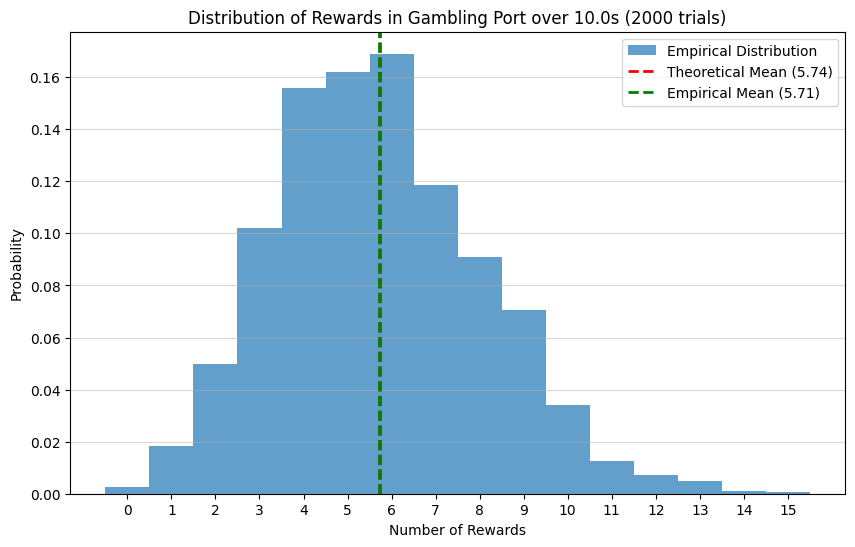

In [7]:
print("\n--- Running Test 3: Statistical Validation of Gambling Port ---")
from tqdm import tqdm
# --- 1. Helper function for the theoretical calculation ---
def calculate_theoretical_rewards(env, wait_duration):
    """Calculates the expected number of rewards for a fixed wait time."""
    expected_rewards = 0
    for t_step in range(int(wait_duration / env.dt)):
        time_in_port = t_step * env.dt
        # We call the environment's own probability function to ensure consistency
        prob = env._get_gambling_reward_prob(time_in_port)
        expected_rewards += prob
    return expected_rewards

# --- 2. Setup and run the simulation trials ---
env = ForagingEnvironment()
env_info = {"time_step_duration": 0.1, "seed": 2077}
env.env_init(env_info)

num_trials = 2000
wait_duration = 10.0  # How long the agent will wait in the gambling port per trial
rewards_per_trial = []

# Calculate the theoretical expectation first
theoretical_avg = calculate_theoretical_rewards(env, wait_duration)
print(f"Running {num_trials} trials, waiting {wait_duration}s each time.")
print(f"Theoretical average rewards per trial: {theoretical_avg:.4f}")

for _ in tqdm(range(num_trials)):
    observation = env.env_start()
    is_terminal = False

    # Dummy Agent Logic:
    # 1. Complete the context port task to unlock the gambling port.
    # 2. Go to the gambling port and wait for `wait_duration`.

    in_gambling_port = False
    rewards_this_trial = 0

    while not is_terminal:
        port_id, time_in_port, _, _, rewards_collected, _ = observation
        action = 0 # Stay by default

        if port_id == env.CONTEXT_PORT and rewards_collected == env.context_rewards_max:
            action = 1 # Leave context
        elif port_id == env.GAMBLING_PORT:
            in_gambling_port = True
            if time_in_port >= wait_duration:
                break # End this trial
        elif (port_id == 2) and (time_in_port >= env.travel_time):
            action = 1

        reward, observation, is_terminal = env.env_step(action)

        # Only count rewards once we are in the gambling port for this test
        if in_gambling_port and reward > 0:
            rewards_this_trial += 1

    rewards_per_trial.append(rewards_this_trial)

# --- 3. Compare empirical results to theoretical expectation ---
empirical_avg = np.mean(rewards_per_trial)
print(f"Empirical average rewards per trial:   {empirical_avg:.4f}")

# --- 4. Rigorous Check ---
# We expect the empirical average to be close to the theoretical one.
# A tolerance of 5% of the theoretical value is reasonable for this many trials.
assert np.isclose(theoretical_avg, empirical_avg, rtol=0.05), "TEST FAILED: Empirical average is too far from theoretical average!"
print("\n--- Test 3 Passed! ---")

# --- 5. Visualize the distribution ---
plt.figure(figsize=(10, 6))
plt.hist(rewards_per_trial, bins=np.arange(max(rewards_per_trial) + 2) - 0.5, density=True, alpha=0.7, label='Empirical Distribution')
plt.axvline(theoretical_avg, color='r', linestyle='--', linewidth=2, label=f'Theoretical Mean ({theoretical_avg:.2f})')
plt.axvline(empirical_avg, color='g', linestyle='--', linewidth=2, label=f'Empirical Mean ({empirical_avg:.2f})')
plt.title(f'Distribution of Rewards in Gambling Port over {wait_duration}s ({num_trials} trials)')
plt.xlabel("Number of Rewards")
plt.ylabel("Probability")
plt.xticks(np.arange(max(rewards_per_trial) + 1))
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

## Test 4: Block Switching Validation


--- Running Test 4: Trial-Aligned Block Switching Validation ---
Test starting in context: Low


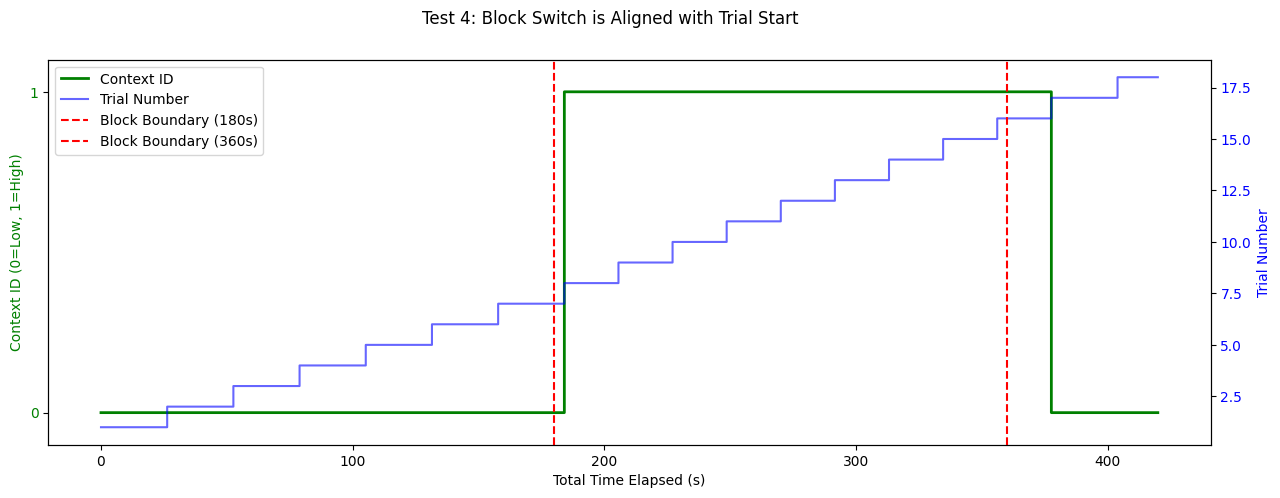

In [8]:
print("\n--- Running Test 4: Trial-Aligned Block Switching Validation ---")

env = ForagingEnvironment()
# Set a session duration long enough to see at least one block switch
env_info = {"time_step_duration": 0.1, "session_duration_min": 7, "seed": 2025}
env.env_init(env_info)

observation = env.env_start()
is_terminal = False

# Store a history of these variables for plotting
history = []
print(f"Test starting in context: {'High' if observation[3] == 1 else 'Low'}")

# This dummy agent completes full trials
while not is_terminal:
    port_id, time_in_port, _, _, rewards_collected, _ = observation
    action = 0 # Default action

    if port_id == 2: # If traveling, enter when time is up
        if time_in_port >= env.travel_time: action = 1
    elif port_id == env.CONTEXT_PORT:
        if rewards_collected == env.context_rewards_max: action = 1 # Leave when finished
    elif port_id == env.GAMBLING_PORT:
        if time_in_port >= 15.0: action = 1 # Leave after 15s

    # Record state *before* the step to align with the time axis
    history.append({
        "time": env.total_time_elapsed,
        "trial": env.env_message("get_trial_number"),
        "context": observation[3]
    })

    _, observation, is_terminal = env.env_step(action)

# --- Plotting ---
time_ax = np.array([h['time'] for h in history])
trial_ax = np.array([h['trial'] for h in history])
context_ax = np.array([h['context'] for h in history])

fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot context on the left y-axis
ax1.plot(time_ax, context_ax, 'g-', drawstyle='steps-post', label='Context ID', linewidth=2)
ax1.set_xlabel('Total Time Elapsed (s)')
ax1.set_ylabel('Context ID (0=Low, 1=High)', color='g')
ax1.set_yticks([0, 1])
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_ylim([-0.1, 1.1])

# Create a second y-axis for the trial number
ax2 = ax1.twinx()
ax2.plot(time_ax, trial_ax, 'b-', drawstyle='steps-post', alpha=0.6, label='Trial Number')
ax2.set_ylabel('Trial Number', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Mark the block boundary
plt.axvline(x=env.block_duration, color='r', linestyle='--', label=f'Block Boundary ({env.block_duration}s)')
plt.axvline(x=env.block_duration * 2, color='r', linestyle='--', label=f'Block Boundary ({env.block_duration * 2}s)')

fig.suptitle("Test 4: Block Switch is Aligned with Trial Start")
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.show()
